# Developing a Baseline Solution

Starting with a simple **baseline** is critical for later comparing the performance of more complex models you develop (they should beat or work comparably to the baseline). 
> Often, baselines can be hard to beat! 

And by investigating the types of errors a baseline makes, you can gain an intuition for where a more complex model may be able to improve.

<img src='notebook_ims/baseline_graphic.png' width=60% />

[Image source, blog post, "Create a Common-Sense Baseline First"](https://towardsdatascience.com/first-create-a-common-sense-baseline-e66dbf8a8a47)

### Formatting a Dataset
In a previous notebook, I cleaned and added columns to a household power consumption dataset; saving the resultant data as train and test pickle files. You can take a look at that data processing notebook if you like, but I recommend skipping it for now, so that you can focus on model training and evaluation. You'll get a chance to focus on data cleaning and transformation later on in this course.

In _this_ notebook, I use this processed data to train a baseline, classical ML model: a linear regression model to predict `Global_active_power`. This is in accordance with my stated goal and hypothesis:
> **Predictive goal**: Predict future active power that a household will need on an hourly basis (e.g, at 9am, 10am, etc.) with high accuracy. The best predictions will avoid underestimating the active power. 

>**Hypothesis**: I think power meter readings and _past_ hourly usage will be great predictors for an ML model. 

### Baseline Model Creation

The baseline creation process will be broken down into the following steps:
>1. Load the data
2. Create train/test datasets
3. Train a linear regression model
4. Evaluate the performance of our trained model on a test dataset
5. Further investigate patterns in errors

I'll start by importing the turicreate library, which I'll use to read in data and train and evaluate a linear regression model. 

In [1]:
# import turicreate which lets us easily create classical ML models
import turicreate as tc
import pandas as pd

---
## Load the Data & Create Train/Test Datasets

Turicreate uses a format called an SFrame, which is very similar to DataFrame types that are used in `pandas` data manipulation, and which you may be more familiar with. An SFrame is just one, efficient format for storing tabular data.

We've already split the data in time, so this is as simple as loading in out two train/test files.

In [2]:
# get train/test pickle files and turn into SFrames
train_path = 'data/train_hourly.pkl'
test_path = 'data/test_hourly.pkl'

train_power_df = pd.read_pickle(train_path)
test_power_df = pd.read_pickle(test_path)

train_power_sf = tc.SFrame(train_power_df)
test_power_sf = tc.SFrame(test_power_df)

### Brief data exploration

I tend to do the bulk of my exploration in a separate notebook where I do data exploration and transformation; you can assume that this work is done at this point.

So, here, I will focus on:
1. Making sure the data was read-in correctly and 
2. Taking a look at the distribution of the target variable: `Global_active_power`.

In [3]:
# SFrames look correct - years are correct and we have our saved columns
train_power_sf


Mean_hourly_power,Std_hourly_power,Start_hr,Voltage,Sub_metering_1,Sub_metering_2
1.0728405075275789,0.9341438099266797,17,234.6438888888889,0.0,0.5277777777777778
1.352090364123325,1.0580806694804061,18,234.58016666666666,0.0,6.716666666666667
1.7885808356723576,1.1518565060169852,19,233.2325,0.0,1.4333333333333333
1.9529222074931454,1.1739992511327662,20,234.07149999999996,0.0,0.0
1.930303706519472,1.1002020490879176,21,237.15866666666665,0.0,0.4166666666666667
1.4382587367208581,0.8991147765124584,22,238.75999999999996,0.0,0.13333333333333333
0.9111828178771005,0.7589158057392149,23,240.61966666666657,0.0,0.08333333333333333
0.6575444501391943,0.6486142756006043,0,240.96183333333332,0.0,0.4666666666666667
0.5339421754146448,0.5276022605689044,1,240.4483333333333,0.0,25.233333333333334
0.47089431485413635,0.42766554319400796,2,245.8186666666667,0.0,0.5666666666666667


In [4]:
#the distribution of the target var in our training data using .show()
target = 'Global_active_power'

## UNCOMMENT to see iframe in-line
train_power_sf[target].show()

Materializing SArray

---
## Train loop: simple linear regression

>In the below cell, I am using turicreate and the `<model>.create()` function, which takes in a training dataset, and the names of my target and input features, and it returns a trained model.

**DOCUMENTATION**: You can read about various models you can create in the turicreate documentation. 
* Here is the link to [tc.linear_regression](https://apple.github.io/turicreate/docs/api/generated/turicreate.linear_regression.LinearRegression.html).
* Here is a link to [a very readable GitBook](https://apple.github.io/turicreate/docs/userguide/) that shows turicreate in the context of several example, ML tasks.

### EXPERIMENT: Including and excluding certain input features

Around this point, I tend to experiment by including one or two input features at a time to train a model. If the addition (or exclusion) of a specific input feature increases my model's accuracy that is useful for me to know as I aim to build the most accurate model! 
* An increase in accuracy --> the feature is a good predictor
* A decrease or no change in accuracy --> the feature is noisy or unrelated to what I am trying to predict (my target)

**Note**: If you run this same code, you may end up with a _sightly_ different model than mine because turicreate _randomly_ selects some validation data to determine when to stop model training. 

In [5]:
# Try adding just one feature at a time to your selected list
# I found that voltage doesn't add much to this model.

# all_input_features = ['Mean_hourly_power', 'Std_hourly_power', 'Start_hr', Voltage', 
#                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

select_input_features = ['Mean_hourly_power', 'Start_hr', 
                         'Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2']

# train/create a baseline linear regression
power_usage_model = tc.linear_regression.create(train_power_sf, 
                                               target = 'Global_active_power',
                                               features=select_input_features) # sf, target, features


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 25337

Number of features          : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 1.064042     | 3.387810           | 2.622605             | 0.462506                        | 0.425908                          |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

---
## Test the Trained Model

Finally, I test my trained model on **test data** which it has NOT seen during training, and evaluate its performance. Testing on unseen data is a good way to check that our model generalizes well, and, in this case, if it can generalize to future data (2010 vs 2006-2009 which it was trained on). 

Turicreate's `.evaluate()` function will take in some test data and return accuracy metrics of `max_error` and `rmse` (root mean squared error), which is a standard measure of error for regression tasks like this. 

In [6]:
# eval on test data 
power_usage_model.evaluate(test_power_sf)

{'max_error': 1.6431471254925998, 'rmse': 0.339107762782971}

### Explainability and Coefficients

One of the great things about a linear model is that this model is represented by a linear equation that _weights_ each input feature by a particular positive or negative value that is indicative of that feature's relationship to the target variable. These values are known as **coefficients** or weights that define the linear equation.

> In the linear equation: `w_1*x_1 + w_2*x_2 + b = 0` we have two inputs (x1, x2) and two coefficients (w1, w2) and a bias/intercept term, b.

For example, a coefficient value of -0.5 for feature 1 indicates that feature 1 is negatively correlated with our target var. 

**Reading coefficient values**

Take a look at the coefficients below, and answer the following questions for yourself to confirm your understanding:
* Which features seem the most strongly related to the target var? In other words, which features have the greatest magnitude for their coefficient value?
* Which features are negatively correlated with the target var, if any?


In [7]:
# coeffs/explainability
power_usage_model.coefficients

name,index,value,stderr
(intercept),None,0.03530482013785252,0.007730898610009193
Mean_hourly_power,None,0.37783114618602315,0.009537751068234799
Start_hr,None,0.005086270500690018,0.0005897247631928908
Sub_metering_3,None,0.06563344897880906,0.0004360808453087441
Sub_metering_1,None,0.07865958001475075,0.0008370045448470424
Sub_metering_2,None,0.06781476841600187,0.0006805945060865197


**Experimental Notes 📝**
* I tried several different combinations of input features
* Mean_hourly_power + Sub_metering_3 alone create a kind of not-bad predictive model with very few inputs
* Mean_hourly_power (which is created by calculating a mean of Global_active_power over _past_ hrs) is consistently a strong predictor, with a high coefficient value for a linear regression model; this confirms my initial hypothesis

---
## Further Comparing Predictions vs Targets

Next, I compare predictied versus target values; first looking at a sample of predictions (using `model.predict()`) over one day (24hrs) worth of test data, and then computing the differences between target and predicted values to get a distribution of errors. 

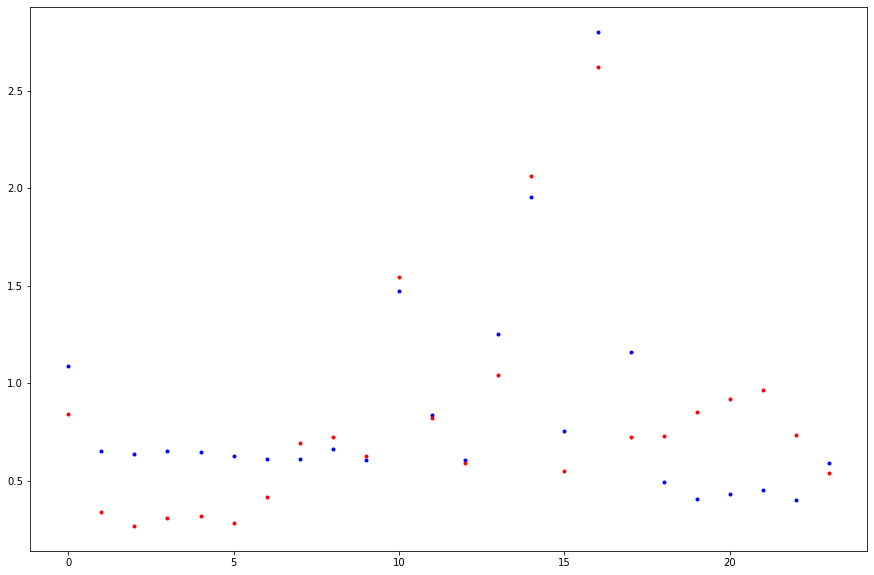

In [8]:
import matplotlib.pyplot as plt
import numpy as np 

%matplotlib inline

plt.figure(figsize=(15,10))

# looking at relationship between predictions and actual power usage for a day of test data
# using np.arange(24) for 24hrs worth of data to compare
plt.plot(np.arange(24),test_power_sf['Global_active_power'][:24],'.b',
         np.arange(24),power_usage_model.predict(test_power_sf)[:24],'.r')

In [9]:
# comparing numerical predictions

test_power_sf['predicted_active_power'] = power_usage_model.predict(test_power_sf)
test_power_sf['target_minus_pred'] = test_power_sf['Global_active_power'] - test_power_sf['predicted_active_power']

test_power_sf

Mean_hourly_power,Std_hourly_power,Start_hr,Voltage,Sub_metering_1,Sub_metering_2
0.6575444501391943,0.6486142756006043,0,241.29999999999993,0.0,0.0
0.5339421754146448,0.5276022605689044,1,241.6206666666666,0.0,0.8
0.47089431485413635,0.42766554319400796,2,244.01233333333337,0.0,0.0
0.4440237235694603,0.3769746706069065,3,244.06383333333335,0.0,0.0
0.4468450083745834,0.3678614263708081,4,241.6493333333333,0.0,0.75
0.460485603290283,0.37673419122826085,5,241.29050000000007,0.0,0.11666666666666667
0.810142608990853,0.540917004327467,6,243.80100000000002,0.0,0.0
1.5038341425055168,0.897723576433203,7,241.8286666666667,0.0,0.11666666666666667
1.4821339302288141,0.7639662488678844,8,240.61033333333341,0.0,0.6333333333333333
1.3323408921885123,0.6571214865607522,9,241.8905,0.0,0.0


In [10]:
## show patterns in error distribution

##uncomment
test_power_sf['target_minus_pred'].show() ## histogram of values...


Materializing SArray

**Observations 📝**
* Errors are centered around zero, a little left skewed with errors ranging from about -1 <-> 1.5, but mostly within a range of -0.5 to 0.2
* Slightly more likely to over-estimate (pred is larger than actual --> negative errors)
* Still some under-estimation which is costly, so may want to do some tuning here or other improvements 
